## Loan lending data analysis

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

#### Data Loading

In [4]:
#reading the data file
data_df = pd.read_csv('C:/Users/Akshay/Downloads/lending-club-loan-data\\loan.csv')
print(data_df.shape)
data_df.head()

(2260668, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


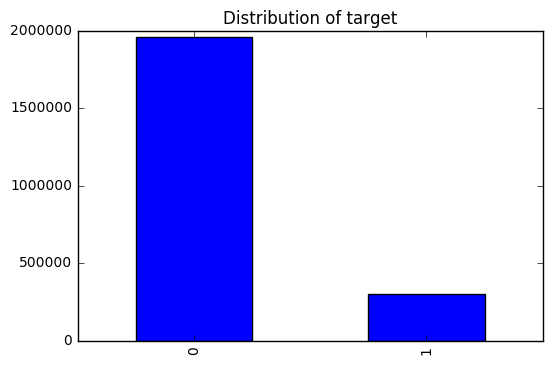

In [5]:
#Target variable and its distribution
data_df['target'] = np.where(data_df.loan_status.isin(['Current','Fully Paid']),0,1 )
ax = data_df['target'].value_counts().plot(kind='bar')
ax.set_title("Distribution of target")

#### Missing values

In [6]:
columns = data_df.columns
percent_missing = data_df.isnull().sum()*100/len(data_df)
missing_value_df = pd.DataFrame({'column_name': columns, 'percent_missing': percent_missing})
missing_value_df.sort('percent_missing', inplace = True, ascending = False)
missing_value_df

,column_name,percent_missing
id,id,100.000000
member_id,member_id,100.000000
url,url,100.000000
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.627278
hardship_dpd,hardship_dpd,99.530537
hardship_status,hardship_status,99.530537
deferral_term,deferral_term,99.530537
hardship_amount,hardship_amount,99.530537
hardship_start_date,hardship_start_date,99.530537
hardship_end_date,hardship_end_date,99.530537


Dropping the columns that have more than 75% missing values as imputing this values would misrepresent the data and it would not add much predictive information

In [7]:
data_proc_na = data_df[data_df.columns[data_df.isnull().mean() < 0.75]]
print(data_proc_na.shape)
data_proc_na.head()

(2260668, 106)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,target
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N,0
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N,0
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N,0
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N,0
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N,0


Process Numerical and Categorical attributes differently

In [8]:
#processing numerical attributes
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = data_proc_na.select_dtypes(include=numerics)

#impute missing values with median
numeric_df = numeric_df.apply(lambda x: x.fillna(x.median()),axis=0)

#filter the columns with '_inv'/removing duplicates
numeric_df = numeric_df[numeric_df.columns.drop(list(numeric_df.filter(regex='_inv')))]

print(numeric_df.shape)
numeric_df.head()

(2260668, 80)


,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target
0,2500,2500,13.56,84.92,55000.0,18.24,0.0,1.0,31.0,9.0,...,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,0
1,30000,30000,18.94,777.23,90000.0,26.52,0.0,0.0,71.0,13.0,...,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,0
2,5000,5000,17.97,180.69,59280.0,10.51,0.0,0.0,31.0,8.0,...,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,0
3,4000,4000,18.94,146.51,92000.0,16.74,0.0,0.0,31.0,10.0,...,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,0
4,30000,30000,16.14,731.78,57250.0,26.35,0.0,0.0,31.0,12.0,...,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,0


In [9]:
#processing categorical variables
cat_df = data_proc_na.select_dtypes(exclude=numerics)

#impute missing values with mode
def fillna_cat(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col
cat_df=cat_df.apply(lambda col:fillna_cat(col))

print(cat_df.shape)
cat_df.head()

(2260668, 23)


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C1,Chef,10+ years,RENT,Not Verified,Dec-2018,Current,n,...,NY,Apr-2001,w,Feb-2019,Mar-2019,Feb-2019,Individual,N,Cash,N
1,60 months,D,D2,Postmaster,10+ years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,LA,Jun-1987,w,Feb-2019,Mar-2019,Feb-2019,Individual,N,Cash,N
2,36 months,D,D1,Administrative,6 years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,MI,Apr-2011,w,Feb-2019,Mar-2019,Feb-2019,Individual,N,Cash,N
3,36 months,D,D2,IT Supervisor,10+ years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,WA,Feb-2006,w,Feb-2019,Mar-2019,Feb-2019,Individual,N,Cash,N
4,60 months,C,C4,Mechanic,10+ years,MORTGAGE,Not Verified,Dec-2018,Current,n,...,MD,Dec-2000,w,Feb-2019,Mar-2019,Feb-2019,Individual,N,Cash,N


In [10]:
#Removing the attributes that will have less predictive ability (by checking manually and grouping over target if the group counts are significant/telling)
cat_df = cat_df.loc[:,~cat_df.columns.isin(['verification_status','pymnt_plan','initial_list_status','last_pymnt_d','last_credit_pull_d','zip_code'])]

In [17]:
#checking for high defaulting employee titles
emp = data_df.groupby('emp_title').agg({'target':'sum'})
emp_def_cnt = emp.apply(lambda x: x.order(ascending=False)).reset_index()
emp_def_cnt.head(20)

,emp_title,target
0,Manager,4578
1,Teacher,4400
2,Owner,3146
3,Driver,2364
4,Supervisor,2037
5,Registered Nurse,1884
6,Sales,1881
7,RN,1797
8,owner,1323
9,manager,1276


In [18]:
#emp titles with high default rates are grouped into 'high_def' and rest are grouped as 'low_def since emp_title contains >50K unique attributes
def_emp = emp_def_cnt['emp_title'].tolist()
cat_df['emp_title'] = np.where(cat_df['emp_title'].isin(def_emp),'high_def','low_def')

#### Label Encode Categorical atttributes

In [19]:
#using label encoder to change to categorical to numerical
cat_le_df = cat_df.apply(LabelEncoder().fit_transform)
cat_le_df.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,loan_status,purpose,title,addr_state,earliest_cr_line,next_pymnt_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,0,2,10,0,1,5,34,1,2,16586,34,46,71,0,0,0,0
1,1,3,16,0,1,1,34,1,2,16586,18,414,71,0,0,0,0
2,0,3,15,0,6,1,34,1,2,16586,22,56,71,0,0,0,0
3,0,3,16,0,1,1,34,1,2,16586,47,239,71,0,0,0,0
4,1,2,13,0,1,1,34,1,2,16586,20,173,71,0,0,0,0


### Feature Reduction

Droping columns that are highly correlated to each other to avoid the issue of Multicolinearity

In [20]:
#combining numerical and categorical attributes
combined_df = pd.concat([numeric_df, cat_le_df], axis=1)

#create confusion matrix
corr_matrix = combined_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
feature_red_df = combined_df.drop(combined_df[to_drop], axis=1)
print(feature_red_df.shape)
feature_red_df.head()

(2260668, 74)


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,...,loan_status,purpose,title,addr_state,earliest_cr_line,next_pymnt_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,13.56,55000.0,18.24,0.0,1.0,31.0,9.0,1.0,4341,...,1,2,16586,34,46,71,0,0,0,0
1,30000,18.94,90000.0,26.52,0.0,0.0,71.0,13.0,1.0,12315,...,1,2,16586,18,414,71,0,0,0,0
2,5000,17.97,59280.0,10.51,0.0,0.0,31.0,8.0,0.0,4599,...,1,2,16586,22,56,71,0,0,0,0
3,4000,18.94,92000.0,16.74,0.0,0.0,31.0,10.0,0.0,5468,...,1,2,16586,47,239,71,0,0,0,0
4,30000,16.14,57250.0,26.35,0.0,0.0,31.0,12.0,0.0,829,...,1,2,16586,20,173,71,0,0,0,0


### Model Building

In [21]:
#train/test split for subset of data
X_train, X_test, y_train, y_test = train_test_split(feature_red_df.iloc[1:90000,], data_df.target.iloc[1:90000,], test_size = 0.3)

In [22]:
X_sel = X_train
sel_test = X_test
xgtrain = xgb.DMatrix(X_sel, label=y_train)

#setting parameters
clf = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=8, ##Since the class weights are highly imbalanced, these weights are set to equalize the ratio of pos to neg classes, dataset has negative to positive ratio of 1:8 
 seed=27)
xgb_param = clf.get_xgb_params()

#cross validation
print ('Start cross validation')
cvresult = xgb.cv(xgb_param, xgtrain, nfold=15, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301)

print('Best number of trees = {}'.format(cvresult.shape[0]))
clf.set_params(n_estimators=cvresult.shape[0])

print('Fit on the trainingsdata')
clf.fit(X_sel, y_train, eval_metric='auc')

print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(X_sel)[:,1]))
print('Predict the probabilities based on features in the test set')
pred = clf.predict_proba(sel_test, ntree_limit=cvresult.shape[0])
pred[:,1]

Start cross validation
Best number of trees = 10
Fit on the trainingsdata
Overall AUC: 1.0
Predict the probabilities based on features in the test set


array([ 0.17928723,  0.17928723,  0.17928723, ...,  0.17928723,
        0.17928723,  0.17928723], dtype=float32)

The results are overfitted since I have considered the subset of data, I couldn't implement/ optimize results on complete dataset due to limited computing resources